In [1]:
# Standard module imports
import numpy as np
import scipy.stats as stats
import pandas as pd

%matplotlib inline

# Useful directories
gh_dir = '/Users/ttshimiz/Github/'
sed_fit_dir = gh_dir + 'bat-agn-sed-fitting/'
casey_dir = sed_fit_dir + 'analysis/casey_bayes_results/'
data_dir = gh_dir + 'bat-data/'

/Users/ttshimiz/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
# Setup the figures
execfile('../code/figure-setup.py')

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [3]:
# Upload the fits for the BAT AGN
bat_casey = pd.read_csv(casey_dir+'beta_fixed_2_wturn_gaussianPrior/final_fit_results_beta_fixed_2_wturn_gaussianPrior.csv', index_col=0)
bat_casey_undetected = pd.read_csv(casey_dir+'beta_fixed_2_wturn_gaussianPrior/final_fit_results_beta_fixed_2_wturn_gaussianPrior_undetected.csv', index_col=0)

# Get rid of the galaxies that are radio-loud and/or have bad fits
bad_sources = np.array(['PICTORA', '3C111.0', '3C120',
                        '2MASXJ23272195+1524375', 'PKS2331-240',
                        'HB890241+622', 'Mrk3'])
bat_casey = bat_casey.drop(bad_sources)

# Upload the info for the BAT AGN (i.e. AGN type, luminosity distance, redshift, etc)
bat_info = pd.read_csv(data_dir+'bat_info.csv', index_col=0)

# Upload the 14-195 keV flux and calculate the luminosity
bat_flux = pd.read_csv(data_dir+'bat_bat_flux.csv', index_col=0)
bat_flux['LBAT'] = 4*np.pi*(bat_info['Dist_[Mpc]']*10**6*3.09e18)**2*bat_flux['BAT_flux']*10**(-12)

In [4]:
# Upload the HRS fits
hrs_casey = pd.read_csv(casey_dir+'hrs_beta_fixed_2_wturn_gaussianPrior/final_fit_results_beta_fixed_2_wturn_gaussianPrior_hrs.csv', index_col=0)

# Upload the HRS info
hrs_info = pd.read_table(gh_dir+'hrs-data/hrs_photometry.txt', delimiter='\t', index_col=0, na_values=-99.99)

In [5]:
# Upload the KINGFISH fits
kf_casey = pd.read_csv(casey_dir+'kingfish_beta_fixed_2_wturn_gaussianPrior/final_fit_results_kingfish_casey.csv', index_col=0)

# Upload teh KINGFISH info
kf_info = pd.read_table('/Users/ttshimiz/Dropbox/Research/Thesis/Other_surveys/KINGFISH/kingfish_data.txt', index_col=0, delimiter='\t')

# Identify the dwarf galaxies as any galaxy with stellar mass < 10^8 Msun
kf_dwarfs = kf_info['Mstar'] < 8.5
kf_agn = (kf_info['Nuc. Type'] == 'AGN') | (kf_info['Nuc. Type'] == 'SF/AGN')
kf_casey['Mstar'] = kf_info['Mstar']

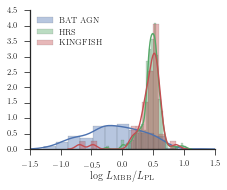

In [6]:
fig = plt.figure(figsize=(columnwidth, 3./4.*columnwidth))
sn.distplot((bat_casey['lir_bb'] - bat_casey['lir_powlaw']).dropna(), label='BAT AGN')
sn.distplot((hrs_casey['lir_bb'] - hrs_casey['lir_powlaw']).dropna(), label='HRS')
sn.distplot((kf_casey.loc[~kf_dwarfs, 'lir_bb'] - kf_casey.loc[~kf_dwarfs, 'lir_powlaw']).dropna(), label='KINGFISH')
plt.xlabel(r'$\log\,L_{\rm MBB}/L_{\rm PL}$')
plt.legend(loc='best')
plt.xlim(-1.5, 1.5)
sn.despine()
plt.savefig(figsave_dir+'lmbb-lpl-ratio.pdf', bbox_inches='tight')

In [6]:
from astropy.stats import sigma_clipped_stats
mean_hrs_ratio, median_hrs_ratio, std_hrs_ratio = sigma_clipped_stats((hrs_casey['lir_bb'] - hrs_casey['lir_powlaw']).dropna())
mean_kf_ratio, median_kf_ratio, std_kf_ratio = sigma_clipped_stats((kf_casey.loc[~kf_dwarfs, 'lir_bb'] - kf_casey.loc[~kf_dwarfs, 'lir_powlaw']).dropna())
mean_ratio, median_ratio, std_ratio = sigma_clipped_stats(np.hstack([(hrs_casey['lir_bb'] - hrs_casey['lir_powlaw']).dropna().values, (kf_casey.loc[~kf_dwarfs, 'lir_bb'] - kf_casey.loc[~kf_dwarfs, 'lir_powlaw']).dropna().values]))
print 'HRS: ',mean_hrs_ratio, median_hrs_ratio, std_hrs_ratio
print 'KINGFISH: ', mean_kf_ratio, median_kf_ratio, std_kf_ratio
print 'All: ', mean_ratio, median_ratio, std_ratio

HRS:  0.479937440175 0.4816471105 0.110685961035
KINGFISH:  0.472729641502 0.49615579598 0.132727536211
All:  0.476177717224 0.481734784 0.113748799478


We can calculate an AGN fraction for the HRS and KINGFISH galaxies assuming they have an AGN. This will give us a constraint on how well we can measure the AGN fraction.

In [7]:
hrs_casey['agn_frac'] = (10**hrs_casey['lir_powlaw'] - 1./3.*10**hrs_casey['lir_bb'])/10**(hrs_casey['lir_total'])
kf_casey['agn_frac'] = (10**kf_casey['lir_powlaw'] - 1./3.*10**kf_casey['lir_bb'])/10**(kf_casey['lir_total'])

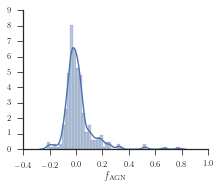

In [10]:
fig = plt.figure(figsize=(columnwidth, 3./4.*columnwidth))
sn.distplot(np.hstack([hrs_casey['agn_frac'].dropna(), kf_casey[~kf_dwarfs]['agn_frac'].dropna()]))
plt.xlabel(r'$f_{\rm AGN}$')
sn.despine()
plt.savefig(figsave_dir+'fagn_nonAGN.pdf', bbox_inches='tight')

In [18]:
nonAGN_fagn = np.hstack([hrs_casey['agn_frac'].dropna(), kf_casey[~kf_dwarfs]['agn_frac'].dropna()])
clipped = stats.sigmaclip(nonAGN_fagn, low=3, high=3)
mean_fagn = np.median(nonAGN_fagn)
std_fagn = np.std(nonAGN_fagn)

print 'AGN fraction of Non-AGN galaxies: ', mean_fagn, '+/-', std_fagn

AGN fraction of Non-AGN galaxies:  -0.00226837288903 +/- 0.110818408046
